In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# Function to design a bandpass filter
def butter_bandpass(lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

In [3]:
# Function to apply a bandpass filter
def bandpass_filter(data, lowcut, highcut, fs, order=2):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, axis=0)
    return y

In [4]:
# Function to read a CSV file, filter, and segmentize it
def segmentize_file(file_path, segment_size=512, overlap=128, lowcut=0.50, highcut=45.0, fs=128):
    data = np.genfromtxt(file_path, delimiter=',')  # Assuming CSV format
    filtered_data = bandpass_filter(data, lowcut, highcut, fs)
    
    num_samples = (len(filtered_data) - segment_size) // overlap + 1
    segments = []
    for i in range(num_samples):
        segment = filtered_data[i * overlap: i * overlap + segment_size, :]
        # Reshape the segment to (1, 512, 14)
        segments.append(segment)
    return segments, filtered_data

In [6]:
# Path to the folder containing the CSV files
folder_path = '/kaggle/input/stew-high-45/ALL high'

In [7]:
# List to store segmented data from all files
all_data = []
all_labels = []

In [8]:
# Define output labels
output_labels = [
   8, 5, 5, 5, 7, 5, 7, 7, 6, 5, 6, 7, 7, 6, 9, 9, 7, 5, 8, 6, 8, 5, 4, 8, 4, 7,
    6, 8, 6, 7, 5, 9, 4, 8, 8, 5, 8, 5, 6, 7, 8, 8, 7, 8, 7
]

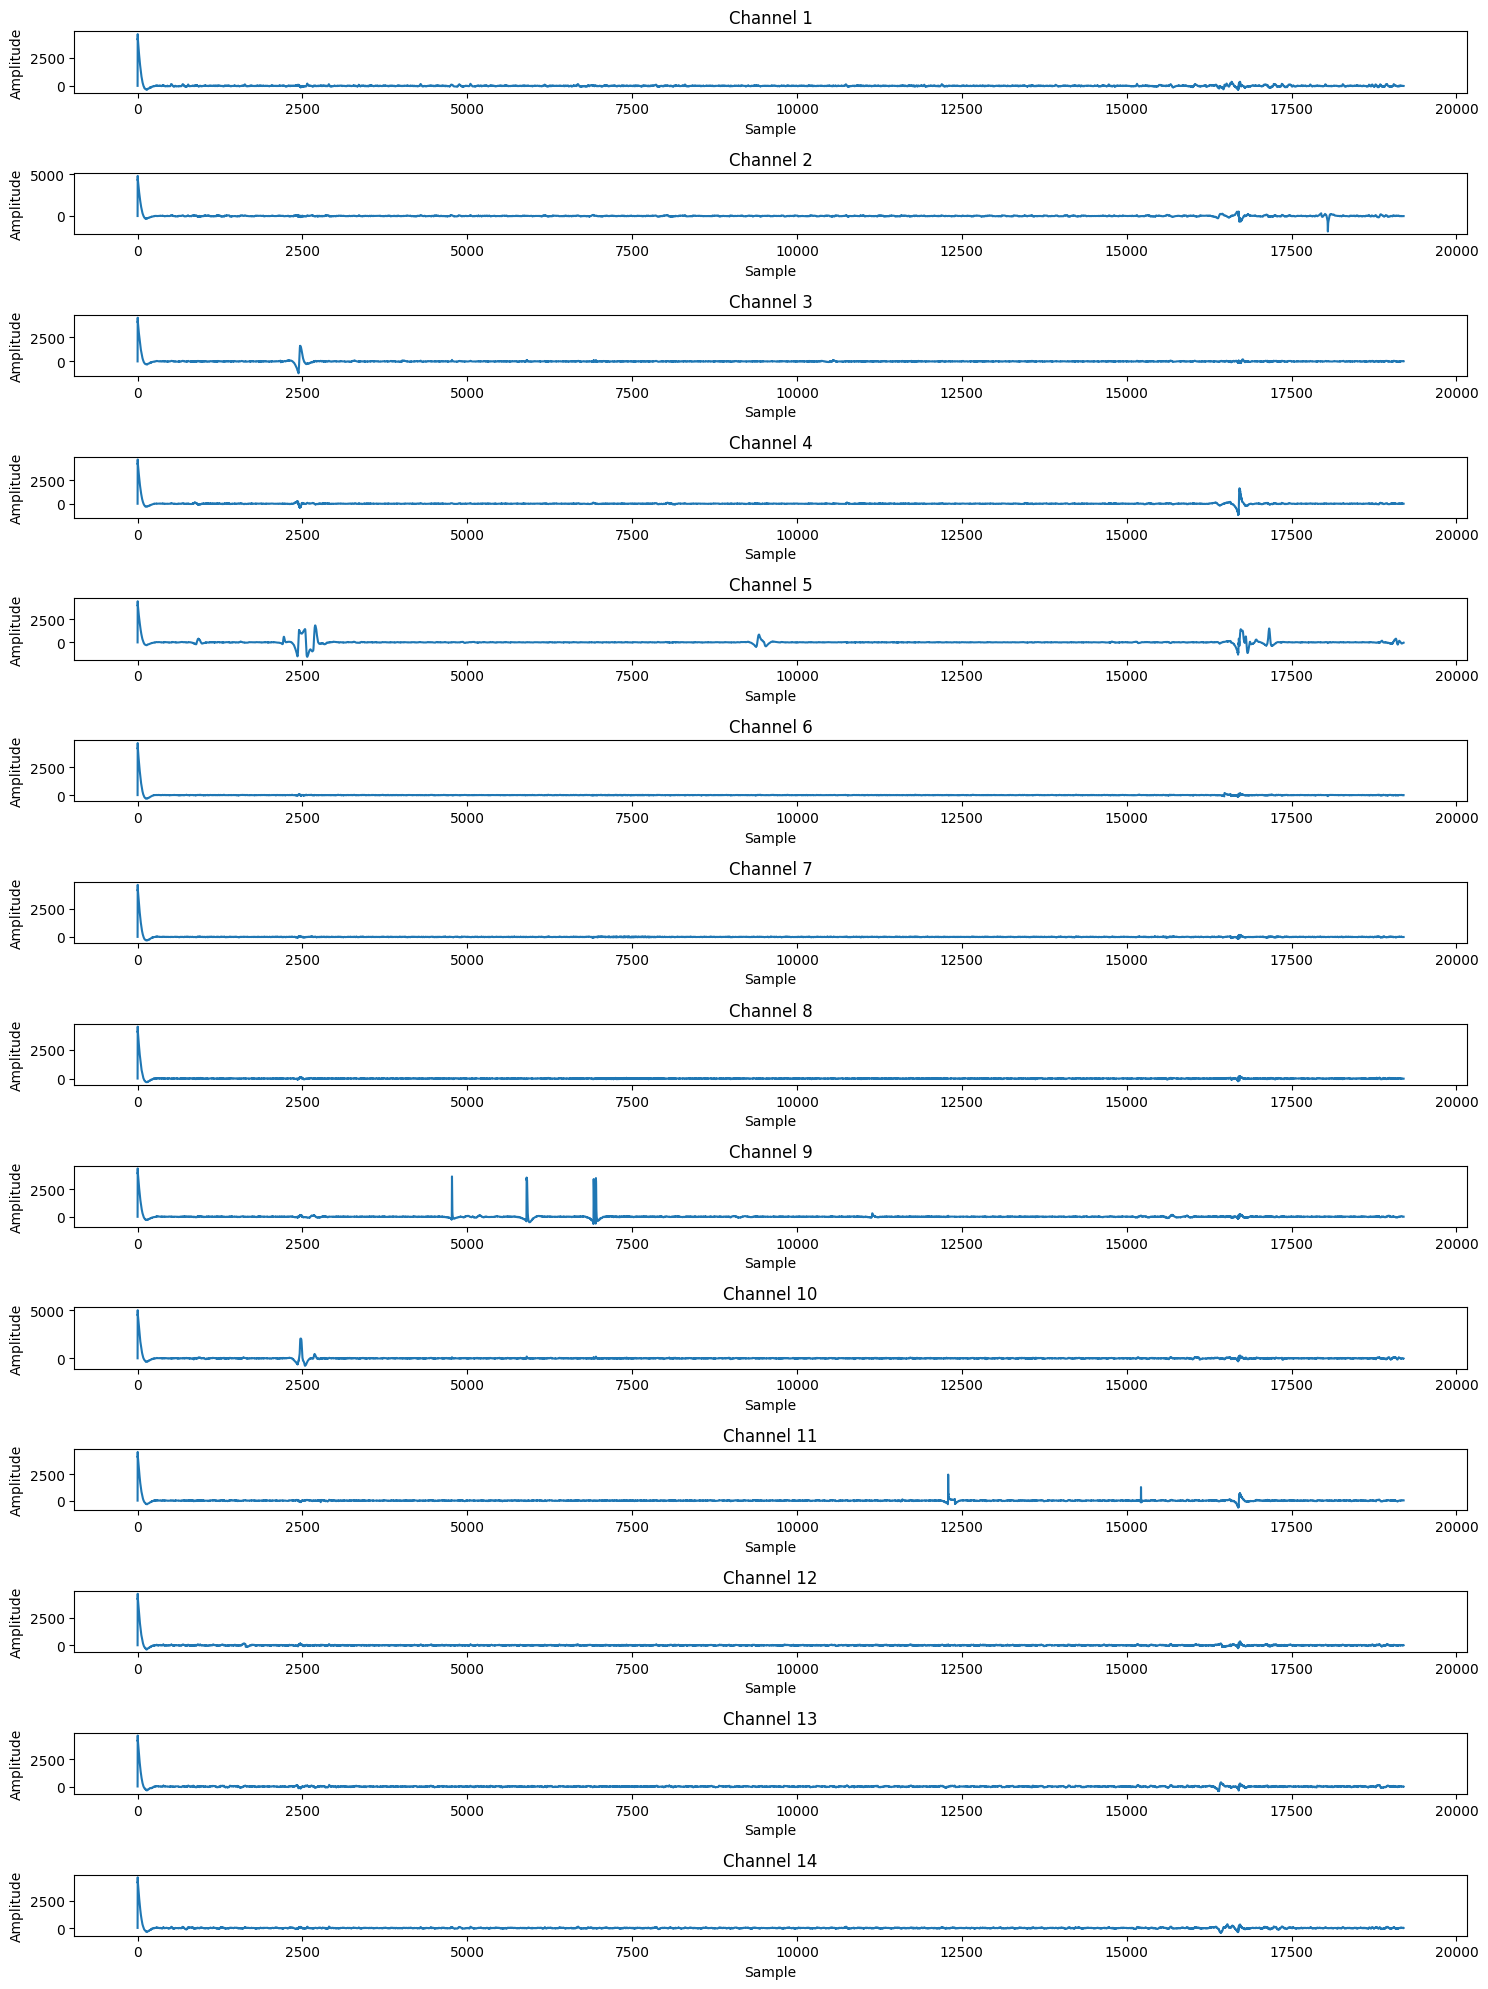

In [9]:
# Iterate through each file in the folder
for idx, filename in enumerate(os.listdir(folder_path)):
    file_path = os.path.join(folder_path, filename)
    if os.path.isfile(file_path):
        segments, filtered_data = segmentize_file(file_path)
        all_data.extend(segments)
        # Replicate each label to match the number of samples
        label = output_labels[idx]
        labels = [label] * len(segments)
        all_labels.extend(labels)

        # Plot the filtered data for all 14 channels for a single subject
        if idx == 0:  # Change the index to plot for a different subject
            plt.figure(figsize=(15, 20))
            for channel in range(filtered_data.shape[1]):
                plt.subplot(14, 1, channel + 1)
                plt.plot(filtered_data[:, channel])
                plt.title(f'Channel {channel + 1}')
                plt.xlabel('Sample')
                plt.ylabel('Amplitude')
            plt.tight_layout()
            plt.show()

In [10]:
# Convert the dataset and labels to numpy arrays
all_data = np.array(all_data)
all_labels = np.array(all_labels)

In [11]:
# Reshape all_data to 2D array for StandardScaler
num_samples, segment_size, num_features = all_data.shape
all_data_reshaped = all_data.reshape(num_samples, -1)

# Apply StandardScaler
scaler = StandardScaler()
all_data_scaled = scaler.fit_transform(all_data_reshaped)

# Reshape back to original shape
all_data_scaled = all_data_scaled.reshape(num_samples, segment_size, num_features)

print(all_data_scaled.shape)  # This should print the shape of the scaled data
print(all_labels.shape)  # This should print the shape of the labels

(6615, 512, 14)
(6615,)


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt



2024-06-23 18:49:05.477212: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-23 18:49:05.477316: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-23 18:49:05.644440: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Binary Classification**

In [13]:
# Define the mapping for the categories
category_mapping = {
    4: 'Low', 5: 'Low', 6: 'Low',
    7: 'High',8: 'High', 9: 'High'
}


In [14]:
# Map y values to categories
y_categories = [category_mapping[val] for val in all_labels]

In [15]:
# Convert y categories to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_categories)


In [17]:
from tensorflow.keras import layers, models, optimizers, Input, Model
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# Convert y_labels to categorical (one-hot encoding)
y_labels_categorical = to_categorical(y_labels)

In [19]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data_scaled, y_labels, test_size=0.2)


#  Resnet_50

In [22]:
# Residual block for ResNet
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [25]:

# ResNet-50 inspired model for 1D data
input_raw = Input(shape=(X_train.shape[1], X_train.shape[2]), name='raw_input')

x = layers.Conv1D(64, 7, strides=2, padding='same')(input_raw)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 128)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)

x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)
x = residual_block(x, 512)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)


In [26]:
# Define the model
model = Model(inputs=input_raw, outputs=output)


In [28]:

# Use the Adam optimizer
adam_optimizer = optimizers.Adam(learning_rate=1e-4, clipnorm=0.5)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
import tensorflow as tf
# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Callback to stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

In [31]:

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=245, validation_split=0.2, validation_data=(X_test, y_test),callbacks=[reduce_lr,early_stopping])


Epoch 1/200


I0000 00:00:1719169521.917086     153 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


22/22 ━━━━━━━━━━━━━━━━━━━━ 117s 2s/step - accuracy: 0.5403 - loss: 0.7850 - val_accuracy: 0.5639 - val_loss: 0.6923 - learning_rate: 1.0000e-04
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.5842 - loss: 0.7510 - val_accuracy: 0.5631 - val_loss: 0.6894 - learning_rate: 1.0000e-04
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.6094 - loss: 0.6934 - val_accuracy: 0.5654 - val_loss: 0.6884 - learning_rate: 1.0000e-04
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.6437 - loss: 0.6686 - val_accuracy: 0.5578 - val_loss: 0.6931 - learning_rate: 1.0000e-04
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6965 - loss: 0.6249 - val_accuracy: 0.4210 - val_loss: 0.7049 - learning_rate: 1.0000e-04
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7340 - loss: 0.5495 - val_accuracy: 0.4203 - val_loss: 0.7224 - learning_rate: 1.0000e-04
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.7787

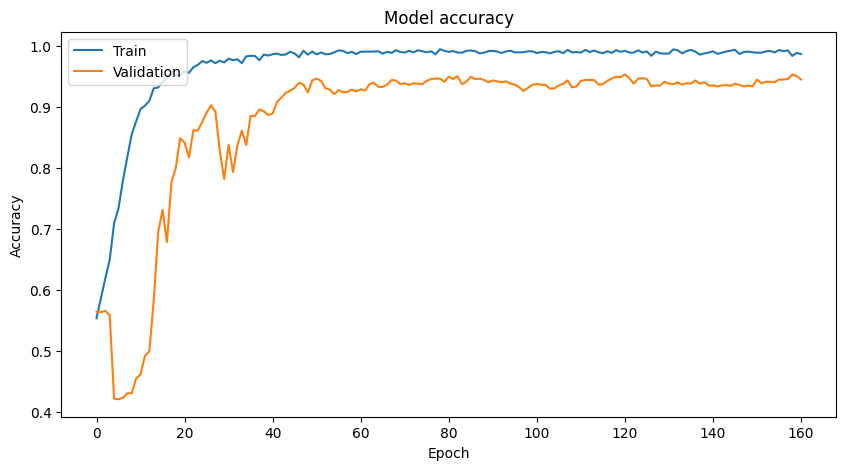

In [32]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

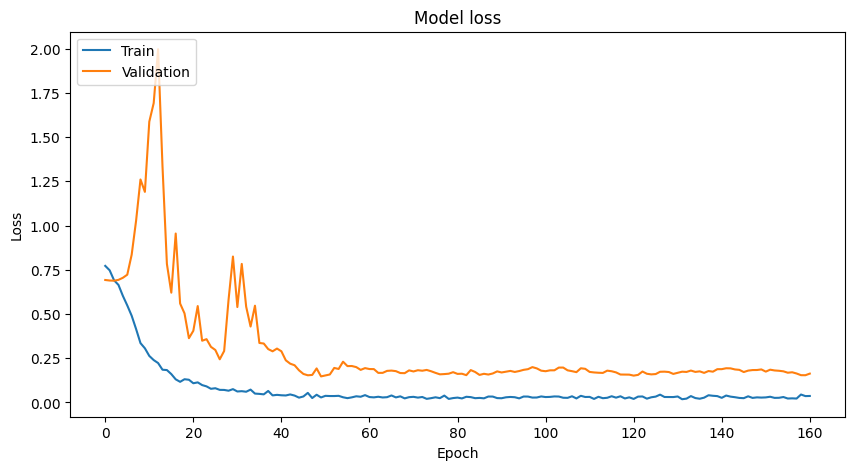

In [33]:

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [35]:
#Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold for binary classification
y_test_labels = y_test  # No need to argmax for binary classification

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Overall Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))


42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step
Overall Accuracy: 0.9531368102796675
              precision    recall  f1-score   support

        High       0.97      0.94      0.96       747
         Low       0.93      0.97      0.95       576

    accuracy                           0.95      1323
   macro avg       0.95      0.95      0.95      1323
weighted avg       0.95      0.95      0.95      1323



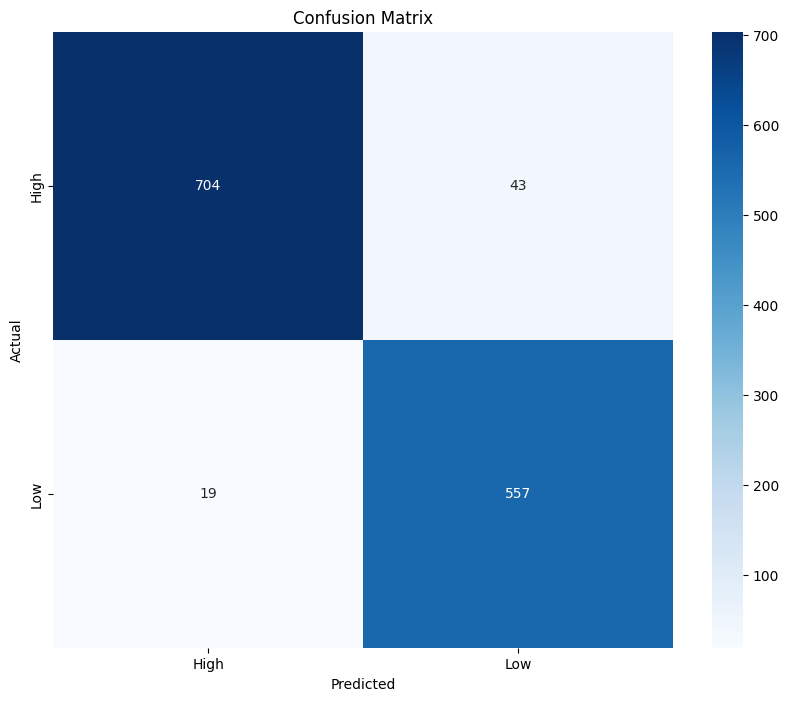

In [36]:

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Resnet_18

In [37]:
# Residual block for ResNet
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# ResNet-18 inspired model for 1D data
input_raw = Input(shape=(X_train.shape[1], X_train.shape[2]), name='raw_input')

x = layers.Conv1D(64, 7, strides=2, padding='same')(input_raw)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)

x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_raw, outputs=output)

# Use the Adam optimizer
adam_optimizer = optimizers.Adam(learning_rate=1e-4, clipnorm=0.5)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Callback to stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=245, validation_split=0.2, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])


Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 914ms/step - accuracy: 0.5636 - loss: 0.7938 - val_accuracy: 0.5601 - val_loss: 0.6929 - learning_rate: 1.0000e-04
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6768 - loss: 0.6111 - val_accuracy: 0.5729 - val_loss: 0.6858 - learning_rate: 1.0000e-04
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.7734 - loss: 0.4628 - val_accuracy: 0.6515 - val_loss: 0.6813 - learning_rate: 1.0000e-04
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8709 - loss: 0.3264 - val_accuracy: 0.5986 - val_loss: 0.6748 - learning_rate: 1.0000e-04
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.8957 - loss: 0.2581 - val_accuracy: 0.4996 - val_loss: 0.6999 - learning_rate: 1.0000e-04
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.9419 - loss: 0.1646 - val_accuracy: 0.5495 - val_loss: 0.6979 - learning_rate: 1.0000e-04
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy

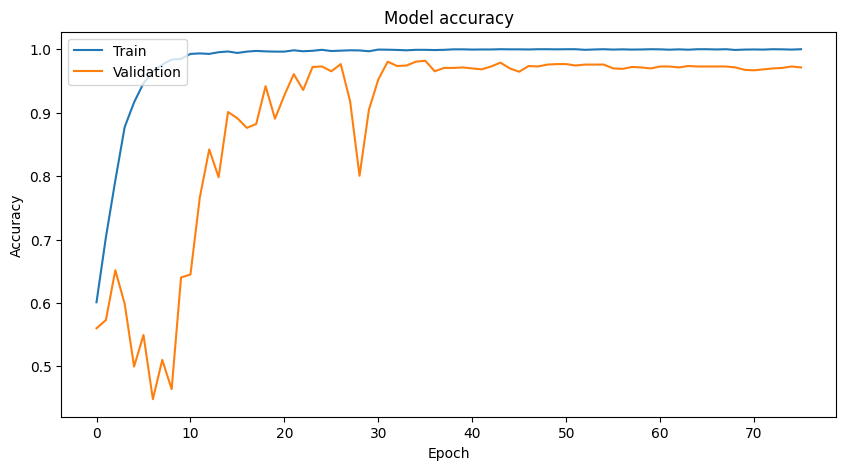

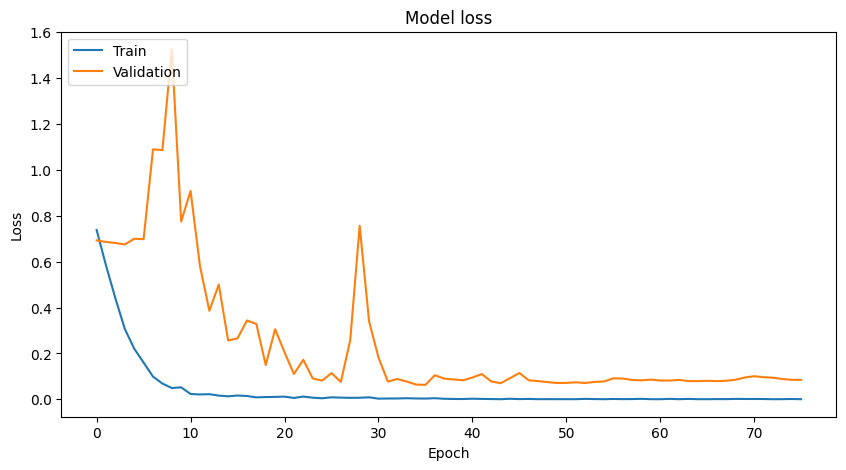

42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step
Overall Accuracy: 0.981859410430839
              precision    recall  f1-score   support

        High       0.99      0.98      0.98       747
         Low       0.98      0.98      0.98       576

    accuracy                           0.98      1323
   macro avg       0.98      0.98      0.98      1323
weighted avg       0.98      0.98      0.98      1323



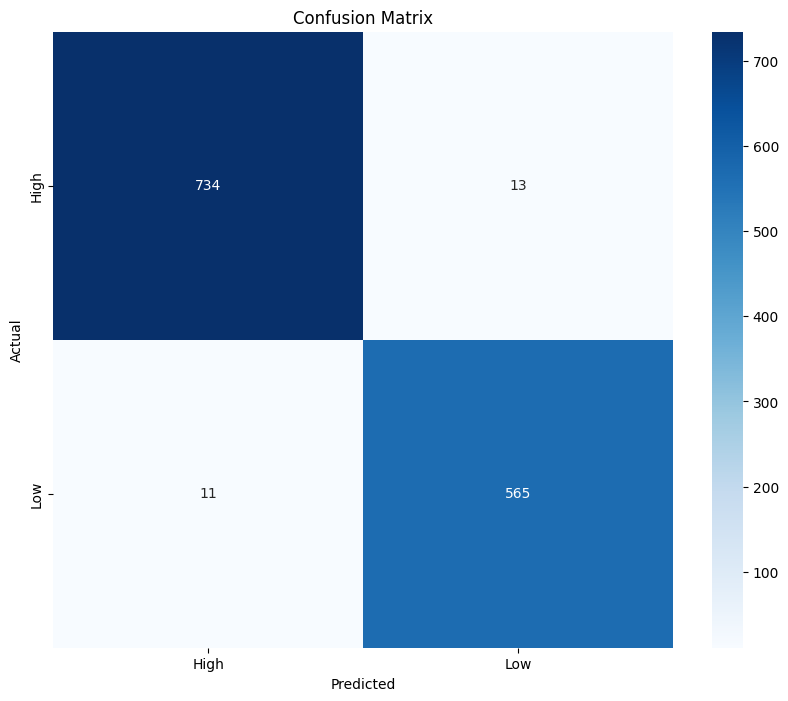

In [38]:

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold for binary classification
y_test_labels = y_test  # No need to argmax for binary classification

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Overall Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# VGG_net

In [39]:
# VGGNet-inspired model for 1D data
input_raw = Input(shape=(X_train.shape[1], X_train.shape[2]), name='raw_input')

# VGG-like block 1
x = layers.Conv1D(64, 3, padding='same', activation='relu')(input_raw)
x = layers.Conv1D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# VGG-like block 2
x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# VGG-like block 3
x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# VGG-like block 4
x = layers.Conv1D(512, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(512, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(512, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# VGG-like block 5
x = layers.Conv1D(512, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(512, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(512, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling1D(pool_size=2, strides=2)(x)

# Fully connected layers
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_raw, outputs=output)

# Use the Adam optimizer
adam_optimizer = optimizers.Adam(learning_rate=1e-4, clipnorm=0.5)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Callback to stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=245, validation_split=0.2, validation_data=(X_test, y_test), callbacks=[reduce_lr, early_stopping])


Epoch 1/200


2024-06-23 19:27:10.499372: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[245,512,1,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[245,512,1,32]{3,2,1,0}, f32[512,512,1,3]{3,2,1,0}, f32[512]{0}), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 19:27:10.706376: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.207179862s
Trying algorithm eng12{k11=2} for conv (f32[245,512,1,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[245,512,1,32]{3,2,1,0}, f32[512,512,1,3]{3,2,1,0}, f32[512]{0}), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is takin

21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5807 - loss: 0.6824

2024-06-23 19:27:46.714712: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[512,512,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,147,1,32]{3,2,1,0}, f32[512,147,1,32]{3,2,1,0}), window={size=1x32 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 19:27:47.449451: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.734898329s
Trying algorithm eng3{k11=2} for conv (f32[512,512,1,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,147,1,32]{3,2,1,0}, f32[512,147,1,32]{3,2,1,0}), window={size=1x32 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convForward", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-06-23 19:27:48.650026: E external/lo

22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.5834 - loss: 0.6810 - val_accuracy: 0.6236 - val_loss: 0.6865 - learning_rate: 1.0000e-04
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.7230 - loss: 0.5738 - val_accuracy: 0.7362 - val_loss: 0.6733 - learning_rate: 1.0000e-04
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.7853 - loss: 0.4627 - val_accuracy: 0.6160 - val_loss: 0.6616 - learning_rate: 1.0000e-04
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.8349 - loss: 0.3873 - val_accuracy: 0.7256 - val_loss: 0.6435 - learning_rate: 1.0000e-04
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.8707 - loss: 0.3069 - val_accuracy: 0.8178 - val_loss: 0.6103 - learning_rate: 1.0000e-04
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9079 - loss: 0.2442 - val_accuracy: 0.8972 - val_loss: 0.5790 - learning_rate: 1.0000e-04
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9344 

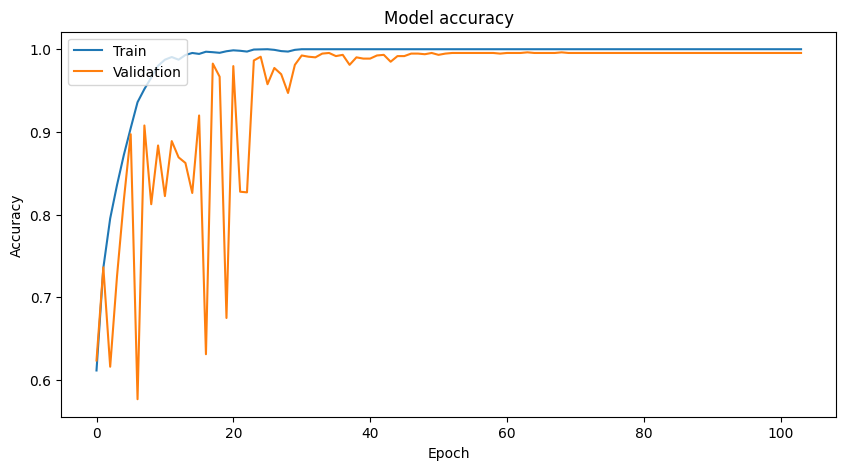

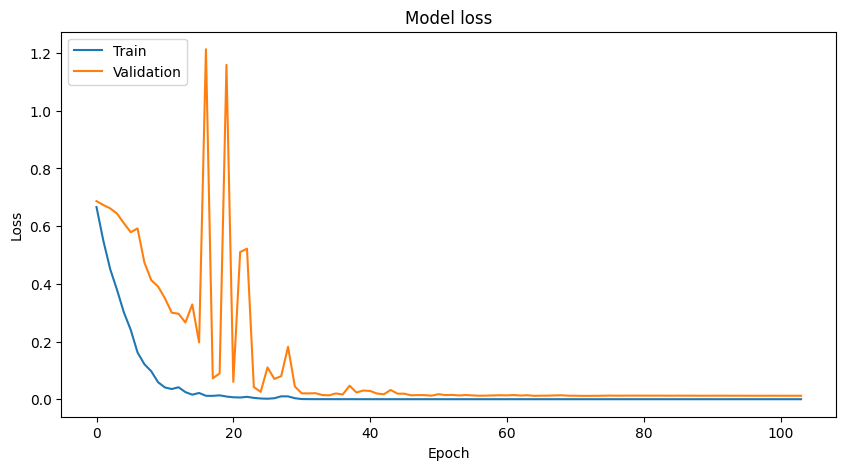

42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step
Overall Accuracy: 0.9962207105064248
              precision    recall  f1-score   support

        High       0.99      1.00      1.00       747
         Low       1.00      0.99      1.00       576

    accuracy                           1.00      1323
   macro avg       1.00      1.00      1.00      1323
weighted avg       1.00      1.00      1.00      1323



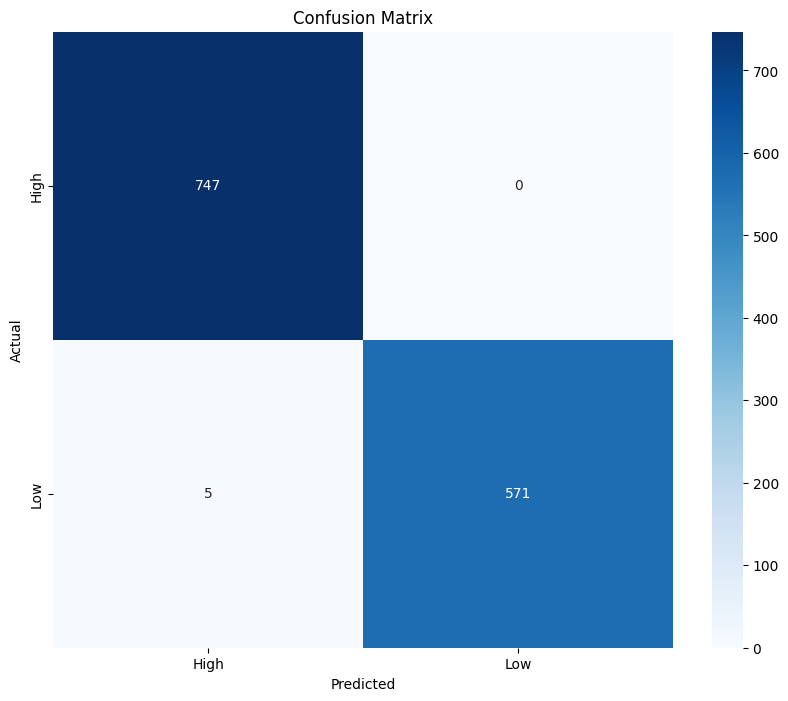

In [40]:

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold for binary classification
y_test_labels = y_test  # No need to argmax for binary classification

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Overall Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [47]:
# Define the mapping for the categories
category_mapping = {
    4: 'Low', 5: 'Low', 6: 'Low', 7: 'High',
    8: 'High', 9: 'High'
}

# Map y values to categories
y_categories = [category_mapping[val] for val in all_labels]

# Convert y categories to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_categories)

# Convert y_labels to categorical (one-hot encoding)
y_labels_categorical = to_categorical(y_labels)


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data_scaled, y_labels, test_size=0.2)

In [49]:
# Residual block for ResNet
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# ResNet-50 inspired model for 1D data
input_raw = Input(shape=(X_train.shape[1], X_train.shape[2]), name='raw_input')

x = layers.Conv1D(64, 7, strides=2, padding='same')(input_raw)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 128)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)

x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)
x = residual_block(x, 512)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_raw, outputs=output)

# Use the Adam optimizer
adam_optimizer = optimizers.Adam(learning_rate=1e-4, clipnorm=0.5)
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Callback to stop training when a monitored metric has stopped improving
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=245, validation_split=0.2, validation_data=(X_test, y_test),callbacks=[reduce_lr])


Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5240 - loss: 0.8213 - val_accuracy: 0.5472 - val_loss: 0.6922 - learning_rate: 1.0000e-04
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.5493 - loss: 0.7630 - val_accuracy: 0.5480 - val_loss: 0.6897 - learning_rate: 1.0000e-04
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.5818 - loss: 0.7308 - val_accuracy: 0.5480 - val_loss: 0.6896 - learning_rate: 1.0000e-04
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.6205 - loss: 0.7158 - val_accuracy: 0.5472 - val_loss: 0.6943 - learning_rate: 1.0000e-04
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 0.6306 - loss: 0.6883 - val_accuracy: 0.5435 - val_loss: 0.7035 - learning_rate: 1.0000e-04
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.6823 - loss: 0.6429 - val_accuracy: 0.5495 - val_loss: 0.7108 - learning_rate: 1.0000e-04
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accur

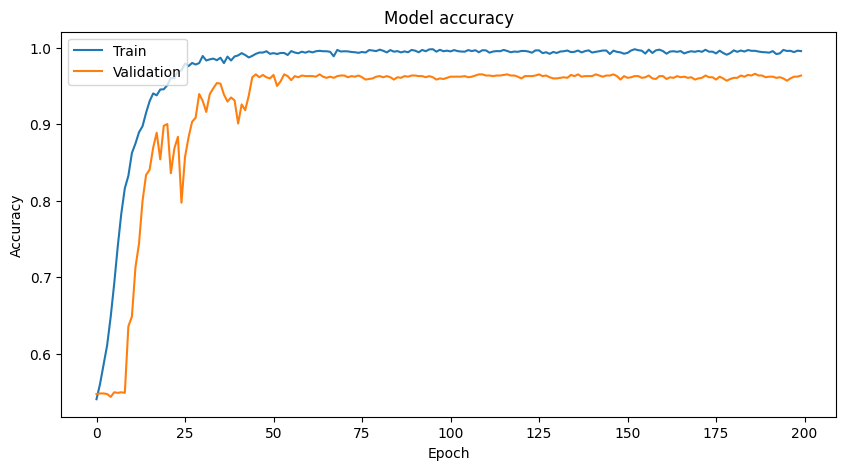

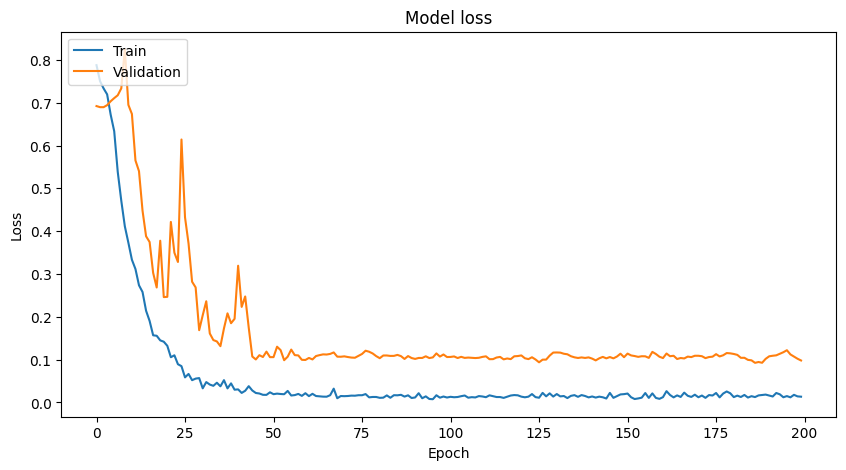

In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()  # Threshold for binary classification
y_test_labels = y_test  # No need to argmax for binary classification

# Calculate accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Overall Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Define the mapping for the categories
category_mapping = {
    4: 'Low', 5: 'Low', 6: 'Moderate', 7: 'Moderate',
    8: 'High', 9: 'High'
}

# Map y values to categories
y_categories = [category_mapping[val] for val in all_labels]

# Convert y categories to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y_labels = label_encoder.fit_transform(y_categories)

# Convert y_labels to categorical (one-hot encoding)
y_labels_categorical = to_categorical(y_labels)

In [44]:

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(all_data_scaled, y_labels, test_size=0.2)


In [45]:
# Residual block for ResNet
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    shortcut = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

# ResNet-50 inspired model for 1D data
input_raw = Input(shape=(X_train.shape[1], X_train.shape[2]), name='raw_input')

x = layers.Conv1D(64, 7, strides=2, padding='same')(input_raw)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling1D(pool_size=3, strides=2, padding='same')(x)

x = residual_block(x, 64)
x = residual_block(x, 64)
x = residual_block(x, 64)

x = residual_block(x, 128, stride=2)
x = residual_block(x, 128)
x = residual_block(x, 128)
x = residual_block(x, 128)

x = residual_block(x, 256, stride=2)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)
x = residual_block(x, 256)

x = residual_block(x, 512, stride=2)
x = residual_block(x, 512)
x = residual_block(x, 512)

x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=input_raw, outputs=output)

# Use the Adam optimizer
adam_optimizer = optimizers.Adam(learning_rate=1e-4, clipnorm=0.5)
model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)

# Callback to stop training when a monitored metric has stopped improving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=40, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=200, batch_size=245, validation_split=0.2, validation_data=(X_test, y_test),callbacks=[reduce_lr,early_stopping])


Epoch 1/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.3697 - loss: 1.4773 - val_accuracy: 0.3930 - val_loss: 1.0969 - learning_rate: 1.0000e-04
Epoch 2/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.3752 - loss: 1.3046 - val_accuracy: 0.3938 - val_loss: 1.0942 - learning_rate: 1.0000e-04
Epoch 3/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 0.3946 - loss: 1.2493 - val_accuracy: 0.3976 - val_loss: 1.0919 - learning_rate: 1.0000e-04
Epoch 4/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.4206 - loss: 1.1984 - val_accuracy: 0.3961 - val_loss: 1.0991 - learning_rate: 1.0000e-04
Epoch 5/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step - accuracy: 0.4709 - loss: 1.1259 - val_accuracy: 0.3983 - val_loss: 1.1030 - learning_rate: 1.0000e-04
Epoch 6/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.5184 - loss: 1.0651 - val_accuracy: 0.3613 - val_loss: 1.1090 - learning_rate: 1.0000e-04
Epoch 7/200
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accur

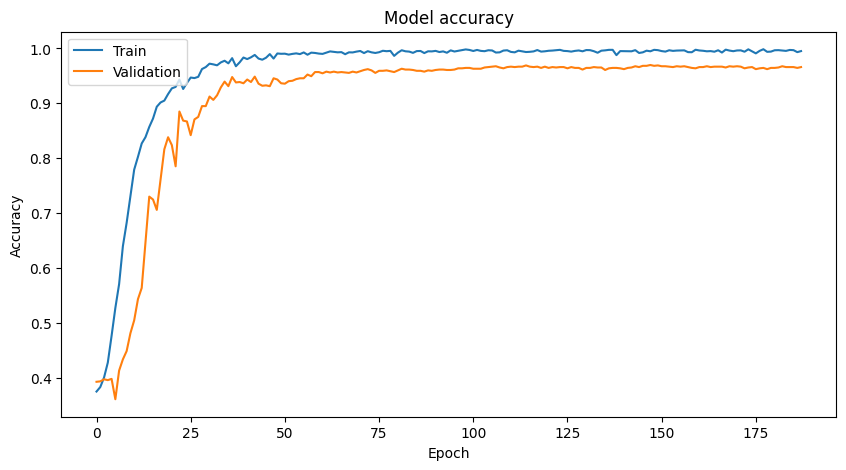

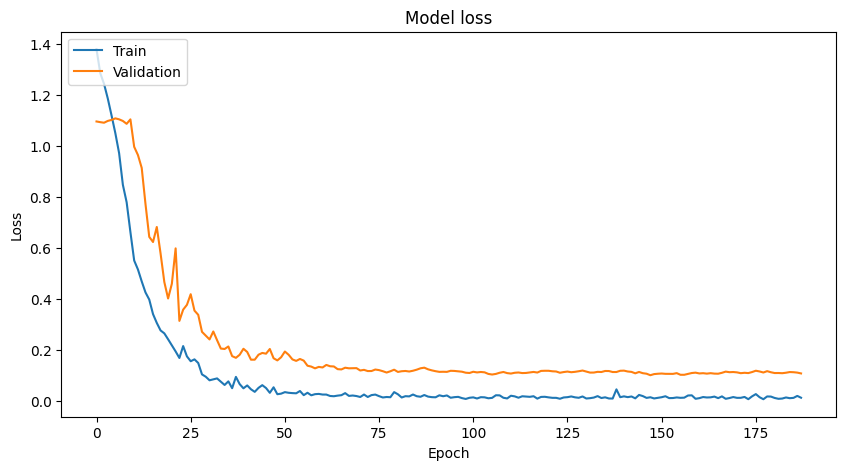

42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step
Overall Accuracy: 0.9697656840513983
              precision    recall  f1-score   support

        High       0.96      0.97      0.97       415
         Low       0.97      0.97      0.97       381
    Moderate       0.97      0.97      0.97       527

    accuracy                           0.97      1323
   macro avg       0.97      0.97      0.97      1323
weighted avg       0.97      0.97      0.97      1323



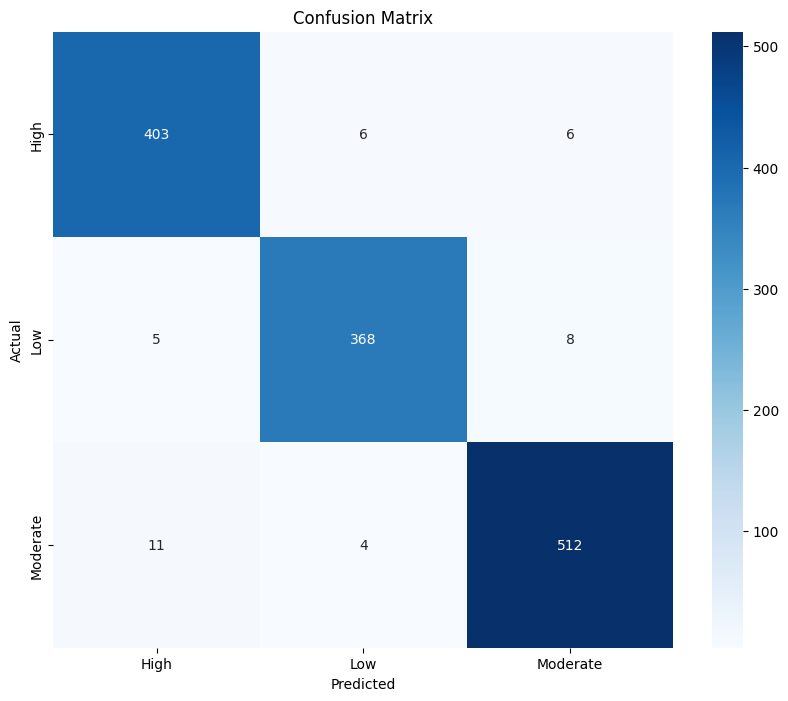

In [46]:

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # For multi-class classification

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Overall Accuracy: {accuracy}")

# Print classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()